In [34]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [66]:
# General libraries
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

# Deep learning libraries
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
#tensorflow..set_random_seed(seed)

In [36]:
!pip install split_folders

In [37]:
root_dir = '/content/drive/MyDrive/COVID-19 Radiography Database'

In [40]:
import splitfolders 
splitfolders.ratio(root_dir, output="Radiographs", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 424 files [00:01, 261.65 files/s]


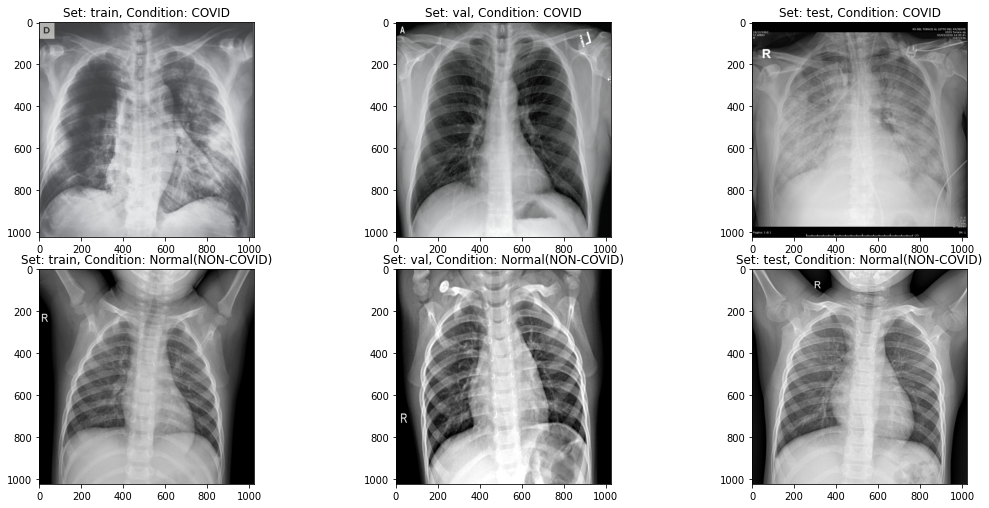

In [41]:
input_path = '/content/Radiographs/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/COVID/'+os.listdir(set_path+'/COVID')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: COVID'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/NON-COVID/'+os.listdir(set_path+'/NON-COVID')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Normal(NON-COVID)'.format(_set))

In [42]:
#Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NON-COVID'))
    n_infect = len(os.listdir(input_path + _set + '/COVID'))
    print('Set: {}, normal images: {}, Covid images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 160, Covid images: 179
Set: val, normal images: 20, Covid images: 22
Set: test, normal images: 20, Covid images: 23


In [89]:
input_path = '/content/Radiographs/'

def process_data(img_dims, batch_size):
    #Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    #This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    val_gen = val_datagen.flow_from_directory(
    directory=input_path+'val', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True) 

    #I will be making predictions off of the test set in one batch size
    #This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NON-COVID/', '/COVID/']:
        for img in (os.listdir(input_path + 'test' + cond)):

            img = image.load_img(input_path+'test'+cond+img, target_size=(150, 150))
            img_tensor = image.img_to_array(img)                   
            img_tensor /= 255.                                     

            if cond=='/NON-COVID/':
                label = 1
            elif cond=='/COVID/':
                label = 0
            test_data.append(img_tensor)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    


    
    return train_gen, val_gen, test_data, test_labels  

In [51]:
from keras.preprocessing import image

In [90]:
# Hyperparameters
img_dims = 150
batch_size = 8

# Getting the data
train_gen, val_gen, test_data, test_labels   = process_data(img_dims, batch_size)

Found 339 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


# Transfer learning

In [61]:
from keras.models import load_model
from tensorflow.keras import layers

In [57]:
new_model = load_model('model.h5') 

In [92]:
print("Number of layers in the base model: ", len(new_model.layers))

Number of layers in the base model:  30


In [93]:
for i in range(len(new_model.layers)): 
    layers.trainable = True   # True--> fine tine, False-->frozen

In [67]:
opt = Adam(learning_rate=0.00003)
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [77]:
epochs=10

In [78]:
# Fitting the model
hist = new_model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=val_gen, 
           validation_steps=val_gen.samples // batch_size)

Epoch 1/10
42/42 [==============================] - 25s 597ms/step - loss: 0.0837 - accuracy: 0.9702 - val_loss: 0.1694 - val_accuracy: 0.9500
Epoch 2/10
42/42 [==============================] - 25s 590ms/step - loss: 0.1255 - accuracy: 0.9637 - val_loss: 0.0522 - val_accuracy: 1.0000
Epoch 3/10
42/42 [==============================] - 25s 592ms/step - loss: 0.1113 - accuracy: 0.9698 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4/10
42/42 [==============================] - 25s 590ms/step - loss: 0.0408 - accuracy: 0.9849 - val_loss: 0.5852 - val_accuracy: 0.8500
Epoch 5/10
42/42 [==============================] - 25s 592ms/step - loss: 0.1089 - accuracy: 0.9637 - val_loss: 0.9996 - val_accuracy: 0.6750
Epoch 6/10
42/42 [==============================] - 25s 588ms/step - loss: 0.0657 - accuracy: 0.9728 - val_loss: 1.0643 - val_accuracy: 0.7000
Epoch 7/10
42/42 [==============================] - 25s 587ms/step - loss: 0.0553 - accuracy: 0.9789 - val_loss: 0.0104 - val_accuracy: 1.0000

In [79]:
new_model.save('Model.h5')

In [80]:
model = load_model('Model.h5')

In [81]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

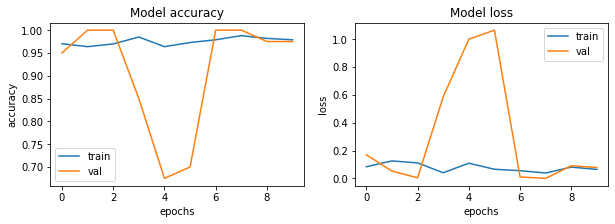

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [94]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

print('\nVALIDATION METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['val_accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[22  1]
 [ 0 20]]

TEST METRICS ----------------------
Accuracy: 97.67441860465115%
Precision: 95.23809523809523%
Recall: 100.0%
F1-score: 97.56097560975608

TRAIN METRIC ----------------------
Train acc: 97.89

VALIDATION METRIC ----------------------
Train acc: 97.5
